In [71]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

Loading data set

In [7]:
data = pd.read_csv("CC.csv")
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Amounts of columns and rows in the data set

In [68]:
data.shape

(10000, 12)

Checking if there is any missing information in the data set(false means there is no null values)

In [69]:
data.isnull().any().any()

False

Data types of each column

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [71]:
data.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

Visualization of Churn rate among our data set (1 meaning churn/0 meaning no churn)

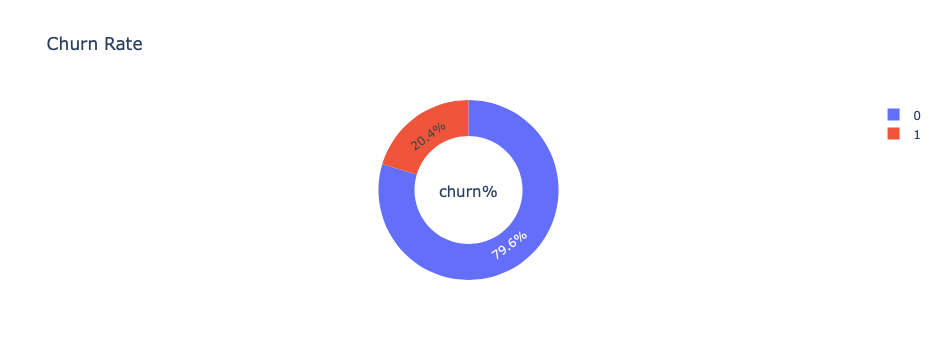

In [26]:
type_ = ["0", "1"]
fig = make_subplots(rows = 1, cols = 1)
fig.add_trace(go.Pie(labels = type_, values = data['churn'].value_counts(), name = "churn"))
fig.update_traces(hole = .6, hoverinfo = "label+percent+name", textfont_size = 12)
fig.update_layout(
    title_text="Churn Rate",
    annotations=[dict(text = 'churn%', x = 0.5, y = 0.5, font_size = 15, showarrow = False)])
fig.show()

Cleaning up the data set 

In [73]:
def cleanCategories(data):
    #selecting the columns we want to work with and separating them from data values
    category = ['gender','country']
    binary = ['credit_card','active_member','churn']
      #changing gender from object ot category
      data.loc[data.gender.str.startswith('F'), 'gender'] = 'Female'  
      data.loc[data.gender.str.startswith('M'), 'gender'] = 'Male'
      #changing credit card, active member, and churn from int to category
      for col in binary:
        if (data[col].dtype == 'object'):  
          data.loc[data[col] == 'yes', col] = '1'
          data.loc[data[col] == 'no', col] = '0'
          data.loc[:,col] = data[col].astype(int)
      #creating boundaries for binary columns
      for col in binary:
        data.loc[:,col].clip(0,1, inplace = True)
      #ensuring that they are all consider category
      for col in category + binary:
        data.loc[:,col] = data[col].astype('category')

In [74]:
cleanCategories(data)
data.dtypes

customer_id            int64
credit_score           int64
country             category
gender              category
age                    int64
tenure                 int64
balance              float64
products_number        int64
credit_card         category
active_member       category
estimated_salary     float64
churn               category
dtype: object

Removed columns that are irrelevant towards churn prediction

In [16]:
newdata = data.drop(["customer_id", "products_number"], axis = 1)
newdata

,credit_score,country,gender,age,tenure,balance,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,1,0,113931.57,1
3,699,France,Female,39,1,0.00,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,1,0,92888.52,1


Categorical data in relation to churn rate

<AxesSubplot:xlabel='country', ylabel='count'>

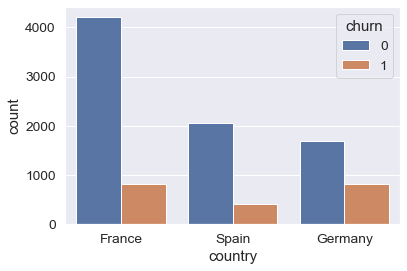

In [38]:
figure = plt.plot(figsize=(5, 5))
sns.set(font_scale = 1.25)
sns.countplot(x = 'country', hue = 'churn', data = data)

<AxesSubplot:xlabel='gender', ylabel='count'>

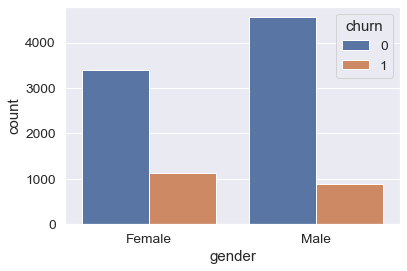

In [37]:
figure = plt.plot(figsize=(5, 5))
sns.set(font_scale = 1.25)
sns.countplot(x = 'gender', hue = 'churn', data = data)

<AxesSubplot:xlabel='credit_card', ylabel='count'>

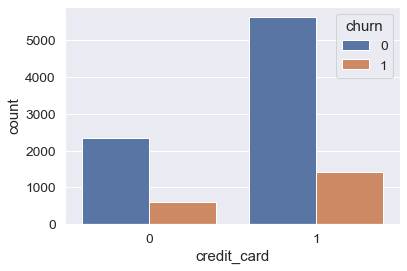

In [36]:
figure = plt.plot(figsize=(5, 5))
sns.set(font_scale = 1.25)
sns.countplot(x = 'credit_card', hue = 'churn', data = data)

<AxesSubplot:xlabel='active_member', ylabel='count'>

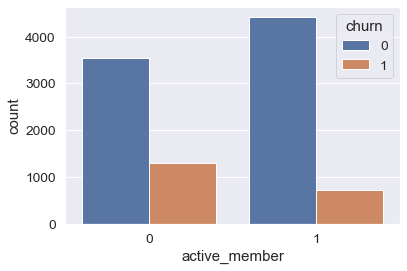

In [35]:
figure = plt.plot(figsize=(5, 5))
sns.set(font_scale = 1.25)
sns.countplot(x = 'active_member', hue = 'churn', data = data)

Numerical data in relation to churn

In [12]:
def findOutliers(data, columns):
    #initialize and empty list
    temp = []
    #we want to keep 3 standard deviations since 99.7% of data lies within
    keepsd = 3 
    for col in columns:
        items = data[col]
        sd = items.std()
        mean = items.mean()
        #retrieving the index of the outliers
        outliers = data[(data[col] > mean + keepsd * sd) | (data[col]  < mean - keepsd * sd)].index
        # and add those index values to our list
        temp += [x for x in outliers]
    return list(set(temp))

Removing the outliers by using the function we created above to locate the outliers

In [20]:
numericalColumns = ["balance", "estimated_salary"]
remove = findOutliers(data, numericalColumns)
newdata.drop(remove, axis = 0, inplace=True)
newdata.describe()

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,1.00000,1.000000,199992.480000,1.000000


Numerical data in relation to churn rate

<AxesSubplot:xlabel='churn', ylabel='estimated_salary'>

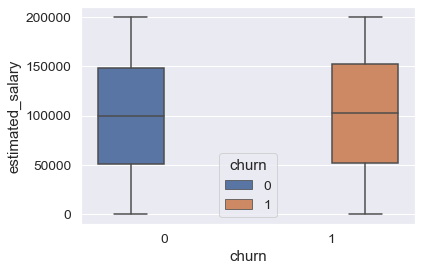

In [39]:
figure = plt.plot(figsize=(20, 12))
sns.set(font_scale = 1.25)
sns.boxplot(y = "estimated_salary", x = "churn", hue = "churn", data = newdata)

<AxesSubplot:xlabel='churn', ylabel='balance'>

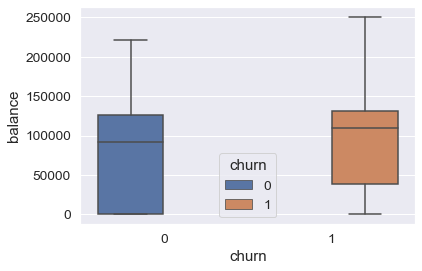

In [34]:
figure = plt.plot(figsize=(20, 12))
sns.set(font_scale = 1.25)
sns.boxplot(y = "balance", x = "churn", hue = "churn", data = newdata)

<AxesSubplot:xlabel='churn', ylabel='age'>

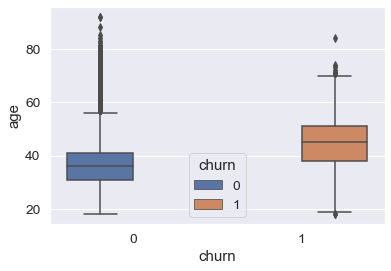

In [40]:
figure = plt.plot(figsize=(20, 12))
sns.set(font_scale = 1.25)
sns.boxplot(y = "age", x = "churn", hue = "churn", data = newdata)

<AxesSubplot:xlabel='churn', ylabel='tenure'>

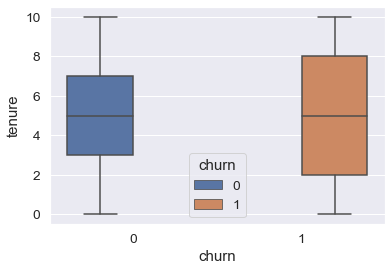

In [150]:
figure = plt.plot(figsize=(20, 12))
sns.set(font_scale = 1.25)
sns.boxplot(y = "tenure", x = "churn", hue = "churn", data = newdata)

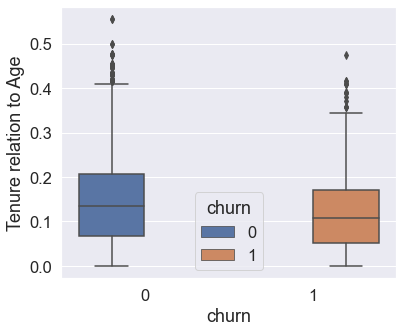

In [157]:
data["Tenure relation to Age"] = data.tenure/(data.age)
plt.figure(figsize=(6, 5))
sns.boxplot(y= "Tenure relation to Age", x = "churn", hue = "churn", data = data)
sns.set(font_scale = 1.5)

Now we are going to dive into the prediction models and first we are going to start by loading the original data set

In [42]:
ogdata = pd.read_csv("CC.csv")
ogdata.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [46]:
twomodels = []
twomodels.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
twomodels.append(("Gradient boost classifier", GradientBoostingClassifier()))

In [68]:
def model_evaluation(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta = 2.0)

    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2]], 
                       columns = ["Model", "Accuracy", "Precision", "Recall",
                                 "F1 SCore", "F2 Score"])
    results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
    return results

In [76]:
#Logistic Regression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
#Gradient Boost
classifier2 = GradientBoostingClassifier()
classifier2.fit(X_train, y_train)
y_pred2 = classifier2.predict(X_test)

In [78]:
logr = model_evaluation(y_test, y_pred, "Logistic Regression")
gradb = model_evaluation(y_test, y_pred2, "Gradient Boost")

In [80]:
evalChart =logr.append(gradb).sort_values(["Precision"], ascending = False).reset_index().drop(columns = "index")
evalChart

,Model,Accuracy,Precision,Recall,F1 SCore,F2 Score
0,Gradient Boost,0.861333,0.774648,0.450082,0.569358,0.491247
1,Logistic Regression,0.796333,0.000000,0.000000,0.000000,0.000000


There seems to be an an issue with Logistic Regression side of the calculation therefore we are going make a second attempt to analyze the logistic regression side.

In [105]:
ogdata2 = pd.read_csv("CC.csv")
droppedogdata2 = ogdata2.drop(["country", "gender"], axis = 1)
droppedogdata2

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,42,3,75075.31,2,1,0,92888.52,1


In [126]:
#we are splitting the input and output into x and y
y = droppedogdata2.churn
X = droppedogdata2.drop(columns=['churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("Train: Response Variable: ",y_train.shape)
print("Train: Feature Variables: ",X_train.shape)
print("Test: Response Variable: ",y_test.shape)
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (7000,)
Train: Feature Variables:  (7000, 9)
Test: Response Variable:  (3000,)
Test: Feature Variables:  (3000, 9)


We are going to create a funciton that allows us to view the results of the logistic regression

In [131]:
def visuals(y_test, y_pred):
  print(accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

In [132]:
Logr = LogisticRegression(solver='lbfgs', C=1, tol=.0001, max_iter=1000)
Logr.fit(X_train, y_train)
y_pred = Logr.predict(X_test)
#using the function created above to visual the data
visuals(y_test, y_pred)

0.7963333333333333
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000



Now we want to retrieve the intercept adn coefficents of the logistic regression

In [136]:
print (f"Logistic Regression Intercept: {Logr.intercept_[0]}")
print (f"\nLogistic Regression Coefficients: {Logr.coef_[0]}")

Logistic Regression Intercept: 2.194141016658705e-14

Logistic Regression Coefficients: [-1.16930595e-07 -5.19669956e-09  3.99107181e-09  2.82086836e-11
  4.66885737e-06 -1.37284622e-11 -3.79129123e-12 -1.06832626e-10
  8.97678511e-07]
